# 영화 관객 수 데이터를 활용한 데이터 분석 
감독, 이름, 상영등급, 스태프 수 등의 정보로 '영화 관객 수'를 예측하는 모델 

In [1]:
import pandas as pd
import lightgbm as lgb

In [2]:
# 데이터 불러오기 

train = pd.read_csv("movies_train.csv")
test = pd.read_csv("movies_test.csv")
submission = pd.read_csv("submission.csv")

In [3]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


* title : 영화 제목 
* distributor : 배급사
* genre : 장르
* releass_time : 개봉일
* time : 상영시간(분)
* screening_rat : 상영등급
* director : 감독이름
* dir_pre_bfnum : 해당 감독이 이 영화를 만들기 전 영화의 평균 관객수 
* dir_prev_num : 해당 감독이 이 영화를 만들기 전 참여한 영화 수
* num_staff : 스텝 수
* num_actor : 주연 배우 수
* box_off_num : 관객 수 : target 

In [4]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


In [5]:
submission.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [6]:
train.shape

(600, 12)

In [7]:
test.shape

(243, 11)

In [8]:
submission.shape

(243, 2)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [10]:
train.describe()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,600.000000,2.700000e+02,600.000000,600.000000,600.000000,6.000000e+02
mean,100.863333,1.050443e+06,0.876667,151.118333,3.706667,7.081818e+05
std,18.097528,1.791408e+06,1.183409,165.654671,2.446889,1.828006e+06
min,45.000000,1.000000e+00,0.000000,0.000000,0.000000,1.000000e+00
25%,89.000000,2.038000e+04,0.000000,17.000000,2.000000,1.297250e+03
50%,100.000000,4.784236e+05,0.000000,82.500000,3.000000,1.259100e+04
75%,114.000000,1.286569e+06,2.000000,264.000000,4.000000,4.798868e+05
max,180.000000,1.761531e+07,5.000000,869.000000,25.000000,1.426277e+07


In [11]:
pd.options.display.float_format = '{:.1f}'.format
train[['genre','box_off_num']].groupby('genre').mean().sort_values('box_off_num')

,box_off_num
genre,
뮤지컬,6627.0
다큐멘터리,67172.3
서스펜스,82611.0
애니메이션,181926.7
멜로/로맨스,425968.0
미스터리,527548.2
공포,590832.5
드라마,625689.8
코미디,1193914.0


In [12]:
pd.reset_option('display.float_format')

In [13]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


In [15]:
import seaborn as sns

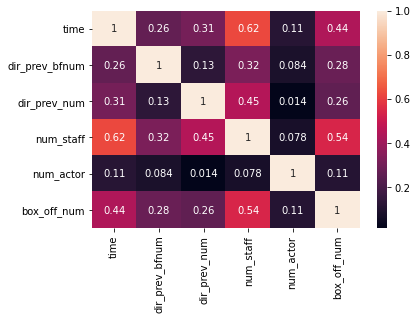

In [16]:
sns.heatmap(train.corr(), annot = True )

결측치 확인 및 처리  
dir_prev_bfnum 에 결측치 존재 -> 0

In [17]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [18]:
train[train['dir_prev_bfnum'].isna()]['dir_prev_num'].sum()

0

In [19]:
test.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

In [20]:
train['dir_prev_bfnum'].fillna(0, inplace=True)
test['dir_prev_bfnum'].fillna(0, inplace=True)

In [22]:
train.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
box_off_num       0
dtype: int64

In [23]:
test.isna().sum()

title             0
distributor       0
genre             0
release_time      0
time              0
screening_rat     0
director          0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
dtype: int64

### 변수 선택 및 모델 구축 

In [25]:
model = lgb.LGBMRegressor(random_state = 777, n_estimators = 1000 )

1번째 features : 시간, 이전 제작참여 영화수, 스텝수, 주연배우 수 

In [30]:
features = ['time', 'dir_prev_num','num_staff', 'num_actor']
target = ['box_off_num']

In [31]:
X_train, X_test, y_train = train[features], test[features], train[target]

In [32]:
# LGBoost 

model.fit(X_train, y_train)

LGBMRegressor(n_estimators=1000, random_state=777)

In [33]:
singleLGBM = submission.copy()

In [34]:
singleLGBM.head()

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0


In [36]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor
0,125,2,304,3
1,113,4,275,3
2,115,3,419,7
3,116,2,408,2
4,110,1,380,1


In [37]:
singleLGBM['box_off_num'] = model.predict(X_test)

In [38]:
singleLGBM.to_csv('singleLGBM.csv', index = False)

#### K-Fold 교차검증 

In [39]:
from sklearn.model_selection import KFold

In [40]:
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)

In [41]:
for train_idx, val_idx  in k_fold.split(X_train):
    print(len(train_idx), len(val_idx))
    break

480 120


In [42]:
model = lgb.LGBMRegressor(random_state = 777, n_estimators = 1000)

In [43]:
models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val),
                           early_stopping_rounds = 100, verbose = 100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.70572e+12
Early stopping, best iteration is:
[6]	valid_0's l2: 2.45438e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.90847e+12
Early stopping, best iteration is:
[33]	valid_0's l2: 3.72825e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.50344e+12
Early stopping, best iteration is:
[8]	valid_0's l2: 2.58737e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.45977e+12
Early stopping, best iteration is:
[11]	valid_0's l2: 1.26226e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.77214e+12
Early stopping, best iteration is:
[22]	valid_0's l2: 1.57631e+12


In [44]:
models 

[LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777),
 LGBMRegressor(n_estimators=1000, random_state=777)]

In [45]:
preds = []
for model in models:
    preds.append(model.predict(X_test))
len(preds)

5

In [46]:
kfoldLightGBM = submission.copy()

In [47]:
import numpy as np

In [48]:
kfoldLightGBM['box_off_num'] = np.mean(preds, axis = 0) 

In [49]:
kfoldLightGBM.head()

,title,box_off_num
0,용서는 없다,3.367422e+06
1,아빠가 여자를 좋아해,9.611389e+05
2,하모니,1.097930e+06
3,의형제,2.097271e+06
4,평행 이론,7.814763e+05


In [50]:
kfoldLightGBM.to_csv('kfoldLightGBM.csv', index = False)

#### Feature Engineering 

In [53]:
features

['time', 'dir_prev_num', 'num_staff', 'num_actor']

In [54]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [55]:
train.genre

0       액션
1      느와르
2       액션
3      코미디
4      코미디
      ... 
595    드라마
596    드라마
597     공포
598    느와르
599     액션
Name: genre, Length: 600, dtype: object

In [56]:
from sklearn import preprocessing 

In [57]:
le = preprocessing.LabelEncoder()

In [58]:
train2 = train.copy()

In [59]:
train2['genre'] = le.fit_transform(train2['genre'])

In [60]:
train2['genre']

0      10
1       2
2      10
3      11
4      11
       ..
595     4
596     4
597     1
598     2
599    10
Name: genre, Length: 600, dtype: int64

In [64]:
train2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    int64  
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  600 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 56.4+ KB


In [62]:
test2 = test.copy()

In [63]:
test2['genre'] = le.fit_transform(test2['genre'])

2번째 Features : 상영시간, 제작영화수, 스텝수, 주연배우 수, 평균 관객수, 장르  

In [65]:
features = ['time','dir_prev_num','num_staff','num_actor','dir_prev_bfnum','genre']

In [66]:
X_train, X_test, y_train = train2[features], test2[features], train2[target]

In [67]:
model = lgb.LGBMRegressor(random_state = 777, n_estimators = 1000)

models = []
k_fold = KFold(n_splits = 5, shuffle = True, random_state = 777)
for train_idx, val_idx in k_fold.split(X_train) : 
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val),
                           early_stopping_rounds =100,verbose = 100))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.62067e+12
Early stopping, best iteration is:
[9]	valid_0's l2: 2.42668e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.39227e+12
Early stopping, best iteration is:
[23]	valid_0's l2: 3.97173e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.29841e+12
Early stopping, best iteration is:
[10]	valid_0's l2: 2.53643e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.56499e+12
Early stopping, best iteration is:
[16]	valid_0's l2: 1.21201e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 1.60118e+12
Early stopping, best iteration is:
[29]	valid_0's l2: 1.47528e+12


In [68]:
X_test.head()

,time,dir_prev_num,num_staff,num_actor,dir_prev_bfnum,genre
0,125,2,304,3,3.005290e+05,2
1,113,4,275,3,3.427002e+05,5
2,115,3,419,7,4.206611e+06,4
3,116,2,408,2,6.913420e+05,10
4,110,1,380,1,3.173800e+04,1


In [69]:
preds = []

for model in models:
    preds.append(model.predict(X_test))
    
len(preds)

5

In [70]:
feLightGBM = submission.copy()

In [71]:
feLightGBM['box_off_num'] = np.mean(preds, axis =0)

In [72]:
feLightGBM.to_csv('feLightGBM.csv', index = False)

#### Grid Search 

In [73]:
from sklearn.model_selection import GridSearchCV

In [74]:
model = lgb.LGBMRegressor(random_state = 777, n_estimators =1000)

In [79]:
params = { 'learning_rate'  : [0.1, 0.01, 0.003],
         'min_child_samples' : [20,30]}

gs = GridSearchCV(estimator = model,
                 param_grid = params,
                 scoring ='neg_mean_squared_error',
                 cv = k_fold)

In [80]:
gs.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=777, shuffle=True),
             estimator=LGBMRegressor(n_estimators=1000, random_state=777),
             param_grid={'learning_rate': [0.1, 0.01, 0.003],
                         'min_child_samples': [20, 30]},
             scoring='neg_mean_squared_error')

In [82]:
gs.best_params_

{'learning_rate': 0.003, 'min_child_samples': 30}

In [83]:
model = lgb.LGBMRegressor(random_state = 777, n_estimators =1000,
                         learning_rate = 0.003, min_child_samples = 30)

models = []

for train_idx, val_idx in k_fold.split(X_train):
    x_t = X_train.iloc[train_idx]
    y_t = y_train.iloc[train_idx]
    
    x_val = X_train.iloc[val_idx]
    y_val = y_train.iloc[val_idx]
    
    models.append(model.fit(x_t, y_t, eval_set = (x_val, y_val),
                 early_stopping_rounds = 100, verbose =100))

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 2.56673e+12
[200]	valid_0's l2: 2.45583e+12
[300]	valid_0's l2: 2.42575e+12
[400]	valid_0's l2: 2.43392e+12
Early stopping, best iteration is:
[335]	valid_0's l2: 2.42348e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 4.89194e+12
[200]	valid_0's l2: 4.40922e+12
[300]	valid_0's l2: 4.19146e+12
[400]	valid_0's l2: 4.05951e+12
[500]	valid_0's l2: 3.96931e+12
[600]	valid_0's l2: 3.91727e+12
[700]	valid_0's l2: 3.88462e+12
[800]	valid_0's l2: 3.87695e+12
[900]	valid_0's l2: 3.87088e+12
Early stopping, best iteration is:
[876]	valid_0's l2: 3.87035e+12
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.14361e+12
[200]	valid_0's l2: 2.79286e+12
[300]	valid_0's l2: 2.59302e+12
[400]	valid_0's l2: 2.47608e+12
[500]	valid_0's l2: 2.40386e+12
[600]	valid_0's l2: 2.36407e+12
[700]	valid_0's l2: 2.38505e+12
Early stopping, best iteration is:
[647]

In [85]:
preds= []

for model in models:
    preds.append(model.predict(X_test))

In [87]:
gs.best_score_

-2334525343085.6494

In [88]:
gslgbm = submission.copy()

In [89]:
gslgbm['box_off_num'] = np.mean(preds, axis =0)

In [90]:
gslgbm.to_csv('gslgbm.csv', index = False)

#### Feature Engineering 

Dtype : Object -> 변환 
1. distributor 배급사
2. genre 장르
3. release_time 개봉일 
4. screening_rat 상영등급 
5. director 감독이름 

In [94]:
train.columns

Index(['title', 'distributor', 'genre', 'release_time', 'time',
       'screening_rat', 'director', 'dir_prev_bfnum', 'dir_prev_num',
       'num_staff', 'num_actor', 'box_off_num'],
      dtype='object')

In [95]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  600 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [98]:
train['screening_rat'].value_counts()

청소년 관람불가    204
15세 관람가     202
12세 관람가     102
전체 관람가       92
Name: screening_rat, dtype: int64

In [107]:
cols = ['distributor','genre','screening_rat']

for col in cols :
    print (train[col].value_counts(), "\n")
    

#for col in cols :    
#    print( train[[col, 'box_off_num']].groupby(col).count(), "\n" )

CJ 엔터테인먼트      54
롯데엔터테인먼트       52
(주)NEW         30
(주)마운틴픽쳐스      29
인디스토리          26
               ..
크리에이티브컴즈(주)     1
롤러코스터 프로덕션      1
KBS미디어(주)       1
두 엔터테인먼트        1
이달투             1
Name: distributor, Length: 169, dtype: int64 

드라마       221
다큐멘터리      93
멜로/로맨스     78
코미디        53
공포         42
액션         28
느와르        27
애니메이션      21
미스터리       17
SF         13
뮤지컬         5
서스펜스        2
Name: genre, dtype: int64 

청소년 관람불가    204
15세 관람가     202
12세 관람가     102
전체 관람가       92
Name: screening_rat, dtype: int64 



배급사 : 169개, 장르 : 12개, 상영등급 : 4개 

In [115]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  600 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [120]:
dis_means = train[['distributor','box_off_num']].groupby('distributor').mean()

In [121]:
dis_means

,box_off_num
distributor,
(주) 브릿지웍스,3598.333333
(주) 액티버스엔터테인먼트,610.000000
(주) 영화사조제,6771.800000
(주) 영화제작전원사,46513.333333
(주) 케이알씨지,1027.285714
...,...
필름라인,5100.000000
하준사,600.000000
한국YWCA연합회,71.000000


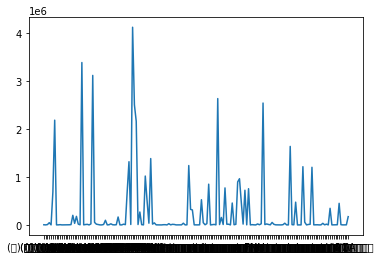

In [128]:
import matplotlib.pyplot as plt
plt.plot(dis_means)
plt.show()

한글 깨짐 해결 

In [137]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

path = '/Users/jihye/Library/Fonts/NanumMyeongjo.ttf'
fontprop = fm.FontProperties(fname =path).get_name()
plt.rcParams["font.family"] = fontprop

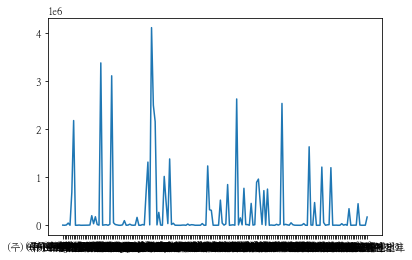

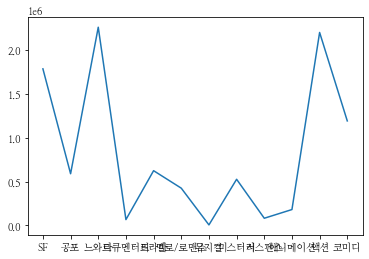

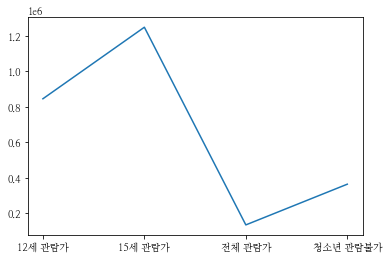

In [139]:
for col in cols :
    co_m = train[[col, 'box_off_num']].groupby(col).mean()
    
    plt.plot(co_m)
    plt.show()